In [1]:
import pandas as pd
import numpy as np

In [2]:
file = pd.read_csv('./all.csv')
file.head()

,topic_id,hot_number,hot_id,create_time,weibo_id,like_number,comment_number,retransmit_number
0,2701,1963479,84343,2019-09-23 19:32:14,I8idbA7CF,565,130,63
1,2701,1963479,84343,2019-09-23 19:32:14,I8hICBe5a,5788,644,339
2,2701,1963479,84343,2019-09-23 19:32:14,I8hKExb8e,4324,554,409
3,2730,1491238,84344,2019-09-23 19:32:18,I8hemi1Ej,835,125,573
4,2730,1491238,84344,2019-09-23 19:32:18,I8hYdrg2Y,5646,135,114


In [3]:
# 计算 各个topic 的个数
from collections import defaultdict

topics = defaultdict(int)
for top in file.topic_id:
    topics[top] += 1

for top in topics:
    if topics[top] > 700:
        print(top)

2757
3653
829
3759


In [4]:
topics[829]

755

In [5]:
# 计算 各个topic 的个数
static_topic = file.groupby(['topic_id'],as_index=False)['topic_id'].agg({'cnt':'count'})
static_topic

,topic_id,cnt
0,370,18
1,611,36
2,661,177
3,749,33
4,780,33
...,...,...
4493,7230,8
4494,7231,9
4495,7232,6
4496,7233,4


In [6]:
static_topic.describe()

,topic_id,cnt
count,4498.000000,4498.000000
mean,4927.162961,100.449978
std,1342.572693,90.406946
min,370.000000,1.000000
25%,3794.250000,30.000000
50%,4934.500000,75.000000
75%,6077.750000,147.000000
max,7234.000000,933.000000


In [7]:
seg = file.loc[(file.topic_id==829)]
len(seg)

755

In [8]:
# 对于相同的时间的进行分组，并求均值
cols = ['hot_number', 'like_number','comment_number', 'retransmit_number']
grouped = seg[cols].groupby(seg.create_time)
seg_group = grouped.mean()

# 求对应特征的增长量 delta
cols = ['like_number','comment_number', 'retransmit_number']
delta = seg_group[cols] - seg_group[cols].shift(1)

# 将not_number拼接，并重置索引
delta = pd.concat([delta, seg_group.hot_number], axis=1)
delta = delta.reset_index()

delta.head()

,create_time,like_number,comment_number,retransmit_number,hot_number
0,2019-09-28 20:44:33,NaN,NaN,NaN,128053.0
1,2019-09-28 20:52:13,-24096.000000,-2747.333333,-12966.666667,471891.0
2,2019-09-28 21:02:10,15222.666667,425.333333,937.000000,1173718.0
3,2019-09-28 21:11:50,-15562.666667,-557.000000,-1239.666667,506663.0
4,2019-09-28 21:21:55,32776.000000,3100.333333,9926.000000,1160811.0


In [9]:
delta

,create_time,like_number,comment_number,retransmit_number,hot_number
0,2019-09-28 20:44:33,NaN,NaN,NaN,128053.0
1,2019-09-28 20:52:13,-24096.000000,-2747.333333,-12966.666667,471891.0
2,2019-09-28 21:02:10,15222.666667,425.333333,937.000000,1173718.0
3,2019-09-28 21:11:50,-15562.666667,-557.000000,-1239.666667,506663.0
4,2019-09-28 21:21:55,32776.000000,3100.333333,9926.000000,1160811.0
...,...,...,...,...,...
258,2019-10-13 13:56:28,-19169.333333,-1089.333333,316.333333,108796.0
259,2019-10-13 14:05:43,20576.333333,1096.666667,1323.000000,106064.0
260,2019-10-13 14:16:41,-8109.666667,-611.333333,-851.000000,106597.0
261,2019-10-13 14:26:00,-17041.666667,-923.666667,-2678.333333,99271.0


In [10]:
from datetime import datetime
from dateutil.parser import parse

# 求取时间段
time = pd.DataFrame(columns=['delta_time'])
time.loc[0] = 0.
for i in range(len(delta)-1):
    time.loc[i+1] = (parse(delta.create_time[i+1]) - parse(delta.create_time[i])).total_seconds() / 60.0  # 计算分钟

# 删除多余的列
delta.drop(['create_time'], axis=1, inplace=True)
#将时间段拼接进来
delta = pd.concat([delta, time], axis=1)
# 去掉 nan
delta.dropna(axis=0, inplace=True)

# 计算各个增长率
cols = ['like_number','comment_number', 'retransmit_number']
delta[cols] = delta[cols].div(delta.delta_time.values, axis=0)

delta

,like_number,comment_number,retransmit_number,hot_number,delta_time
1,-3142.956522,-358.347826,-1691.304348,471891.0,7.666667
2,1529.916248,42.747069,94.170854,1173718.0,9.950000
3,-1609.931034,-57.620690,-128.241379,506663.0,9.666667
4,3250.512397,307.471074,984.396694,1160811.0,10.083333
5,-2053.071104,-246.142209,-899.848714,521547.0,11.016667
...,...,...,...,...,...
258,-378.466601,-21.507075,6.245475,108796.0,50.650000
259,2224.468468,118.558559,143.027027,106064.0,9.250000
260,-739.483283,-55.744681,-77.598784,106597.0,10.966667
261,-1829.159213,-99.141324,-287.477639,99271.0,9.316667


In [11]:
delta.drop(['delta_time'], axis=1, inplace=True)

In [12]:
def split_data(data, training_size=0.8):
    return data[:int(training_size*len(data))], data[int(training_size*len(data)):]

In [13]:
train_set, test_set = split_data(delta)
train_set

,like_number,comment_number,retransmit_number,hot_number
1,-3142.956522,-358.347826,-1691.304348,471891.0
2,1529.916248,42.747069,94.170854,1173718.0
3,-1609.931034,-57.620690,-128.241379,506663.0
4,3250.512397,307.471074,984.396694,1160811.0
5,-2053.071104,-246.142209,-899.848714,521547.0
...,...,...,...,...
205,-1580.036101,-82.996390,-83.826715,188664.0
206,1165.182724,71.295681,95.980066,168104.0
207,-1284.693878,-88.163265,-110.102041,158660.0
208,1029.836601,45.032680,-7.516340,144512.0


In [14]:
window_len = 4
train_batch_size = 16
test_batch_size = 8
cols = ['hot_number', 'like_number','comment_number', 'retransmit_number']

In [15]:
def create_inputs(data, window_len=window_len, cols=cols):
    inputs = []
    for i in range(len(data) - window_len):
        temp_set = data[i:(i + window_len)].copy()
        inputs.append(temp_set)
        for col in cols:
            inputs[i].loc[:, col] = inputs[i].loc[:, col] / (inputs[i].loc[:, col].iloc[0] + 1.0) - 1
            #inputs[i][cols] = (inputs[i][cols] - inputs[i][cols].min()) / (inputs[i][cols].max()-inputs[i][cols].min() + 1)
    return inputs

def create_outputs(data, window_len=window_len):
    return (data['hot_number'][window_len:].values / data['hot_number'][:-window_len].values) - 1

def to_array(data):
    x = [np.array(data[i]) for i in range (len(data))]
    return np.array(x)

In [16]:
X_train, X_test = create_inputs(train_set), create_inputs(test_set)
Y_train, Y_test = create_outputs(train_set), create_outputs(test_set)

X_train, X_test = to_array(X_train), to_array(X_test)

In [17]:
print(X_train.shape)   # (all_data, seq, features)
X_test

(205, 4, 4)


array([[[-4.14807484e-04, -7.43042258e-03, -8.60326004e-03,
         -7.99808046e-06],
        [-2.14491056e+00, -2.15884570e+00, -2.08221480e+00,
         -3.07878109e-01],
        [ 1.42714715e-01,  1.55013762e-01,  8.02351295e-02,
         -3.74502119e-01],
        [-2.15758754e+00, -2.17070155e+00, -2.09461512e+00,
         -3.50411901e-01]],

       [[ 3.62436894e-04,  6.45329509e-03,  8.01338262e-03,
         -1.15557507e-05],
        [-1.99844383e+00, -2.00312527e+00, -2.00616945e+00,
         -9.62709592e-02],
        [ 1.14389176e-02,  1.67500586e-02,  1.95634863e-02,
         -6.14650381e-02],
        [-1.66460953e+00, -1.81467437e+00, -2.09901660e+00,
         -1.65905913e-01]],

       [[-3.62870065e-04, -6.39206827e-03, -7.90131953e-03,
         -1.27865792e-05],
        [-2.01264775e+00, -2.00710346e+00, -2.00530541e+00,
          3.85003900e-02],
        [-3.34596151e-01, -1.93055006e-01,  8.36474139e-02,
         -7.70647129e-02],
        [-9.89125994e-01, -4.19813270e-

In [18]:
print(Y_test.shape)
Y_train.shape

(49,)


(205,)

In [19]:
import torch
import matplotlib.pyplot as plt
import torch.utils.data as Data

In [20]:
# 创建 Dataset 对象，用于后面的训练
train_dataset = Data.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
test_dataset = Data.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

In [21]:
train_iter = Data.DataLoader(train_dataset, train_batch_size, shuffle=True)
test_iter = Data.DataLoader(test_dataset, test_batch_size, shuffle=True)

In [27]:
import torch
from torch import nn
from torch.utils.data import DataLoader

epochs = 150
lr = 5e-4
window_len = 4
input_size = 4
hidden_size = 128
num_layers = 2
dropout = 0.25

class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=num_layers, dropout=dropout):
        super(RNN_model, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout)
        # 输出是 hot_number ，是一个一维的值
        self.linear = nn.Linear(hidden_size, out_features=1)

    def forward(self, input):
        # input : [batch, seq, hidden_size]，但 rnn 要求的输入是 [seq, batch, hidden_size]
        output, (_,_) = self.rnn(input.permute(1,0,2))
        # return 的维度是 [batch, hidden_size]
        return self.linear(output[-1])
    

def train(train_iter, test_iter, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        l_loss = 0.
        for X, Y in train_iter:
            optimizer.zero_grad()
            l = loss(model(X.float()).squeeze(), Y.float())
            l.backward()
            optimizer.step()
            l_loss += l.item()

        train_loss.append(l_loss / len(train_iter))
        eval_loss = eval(test_iter, model, loss)
        test_loss.append(eval_loss)
        print('epoch: {}, train loss :{}'.format(epoch, l_loss / len(train_iter)))
        print('epoch: {}, eval loss :{}'.format(epoch, eval_loss))
    return train_loss, test_loss


def eval(test_iter, model, loss):
    model.eval()
    l_loss = 0.
    for X, Y in test_iter:
        with torch.no_grad():
            l = loss(model(X.float()).squeeze(), Y.float())
            l_loss += l.item()
    
    return l_loss / len(test_iter)

In [28]:
model = RNN_model(input_size, hidden_size)
train_loss, test_loss = train(train_iter, test_iter, model)

epoch: 0, train loss :1.0021272702858999
epoch: 0, eval loss :0.21458219204630172
epoch: 1, train loss :0.9872477994515345
epoch: 1, eval loss :0.24088914692401886
epoch: 2, train loss :0.9195688458589407
epoch: 2, eval loss :0.19851505224193847
epoch: 3, train loss :0.8869706300588754
epoch: 3, eval loss :0.2021129493202482
epoch: 4, train loss :0.827714130282402
epoch: 4, eval loss :0.19473149414573396
epoch: 5, train loss :0.7296495896119338
epoch: 5, eval loss :0.1807932491813387
epoch: 6, train loss :0.6373869776725769
epoch: 6, eval loss :0.1779818098459925
epoch: 7, train loss :0.6090348672408324
epoch: 7, eval loss :0.15464436568851983
epoch: 8, train loss :0.5849244376787772
epoch: 8, eval loss :0.15848438441753387
epoch: 9, train loss :0.5697649384920414
epoch: 9, eval loss :0.13025887217372656
epoch: 10, train loss :0.5203462879245098
epoch: 10, eval loss :0.1558788445379053
epoch: 11, train loss :0.5071900315009631
epoch: 11, eval loss :0.12311705547784056
epoch: 12, train 

epoch: 98, train loss :0.33780282735824585
epoch: 98, eval loss :0.06887077300676278
epoch: 99, train loss :0.29048340710309833
epoch: 99, eval loss :0.06830403885396663
epoch: 100, train loss :0.30191335196678454
epoch: 100, eval loss :0.06979214759277445
epoch: 101, train loss :0.2899098422808143
epoch: 101, eval loss :0.07447209881086435
epoch: 102, train loss :0.283899400383234
epoch: 102, eval loss :0.06766092082086418
epoch: 103, train loss :0.33319236080233866
epoch: 103, eval loss :0.06305804456185017
epoch: 104, train loss :0.2789503410458565
epoch: 104, eval loss :0.0780716243066958
epoch: 105, train loss :0.2933572674026856
epoch: 105, eval loss :0.06834731329165931
epoch: 106, train loss :0.285147437109397
epoch: 106, eval loss :0.066924104820438
epoch: 107, train loss :0.28277319125258005
epoch: 107, eval loss :0.13763348385691643
epoch: 108, train loss :0.28264902704037154
epoch: 108, eval loss :0.07574344053864479
epoch: 109, train loss :0.2860003408904259
epoch: 109, ev

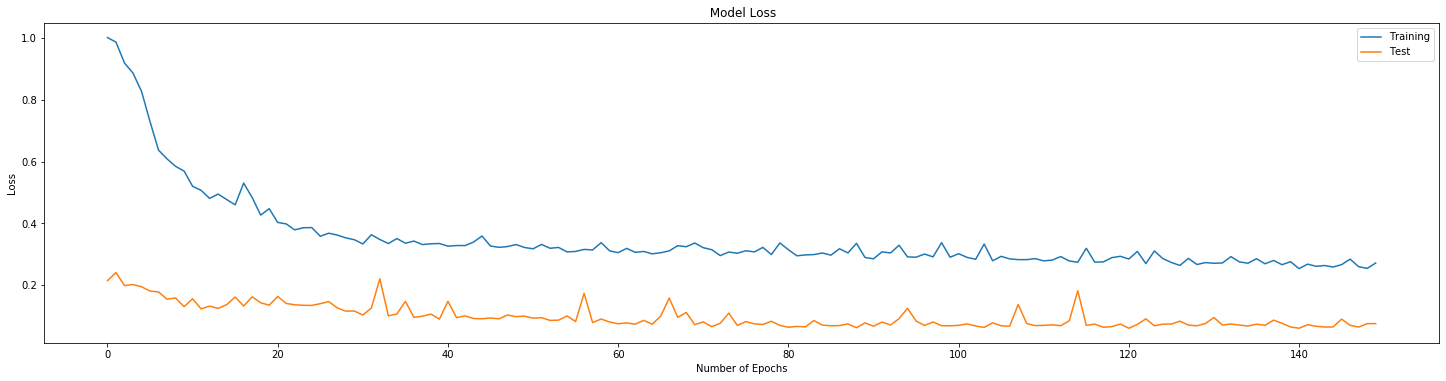

In [29]:
plt.figure(figsize=(25, 20))
plt.subplot(311)
plt.plot([i for i in range(epochs)], train_loss)
plt.plot([i for i in range(epochs)], test_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title(' Model Loss')
plt.legend(['Training', 'Test'])
plt.show()

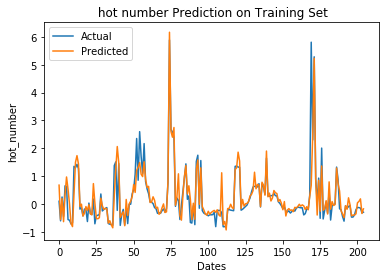

In [30]:
plt.subplot(111)
plt.plot(torch.tensor(Y_train))
model.eval()
prediction = model(torch.tensor(X_train).float()).squeeze().detach().numpy()
plt.plot(prediction)
plt.xlabel('Dates')
plt.ylabel('hot_number')
plt.title(' hot number Prediction on Training Set')
plt.legend(['Actual','Predicted'])

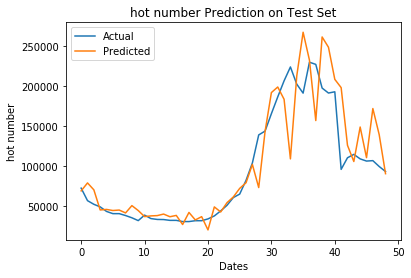

In [31]:
ax1 = plt.subplot(111)
plt.plot(test_set['hot_number'][window_len:].values.tolist())
model.eval()
prediction = model(torch.tensor(X_test).float()).squeeze().detach().numpy()
plt.plot(((prediction + 1) * test_set['hot_number'].values[:-window_len]))
plt.xlabel('Dates')
plt.ylabel('hot number')
plt.title('hot number Prediction on Test Set')
plt.legend(['Actual','Predicted'])
  
# date_list = date_labels()
# ax1.set_xticks([x for x in range(len(date_list))])
# for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
#     label.set_visible(False)

plt.show()

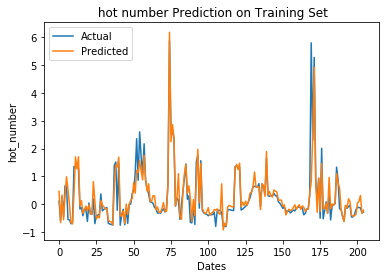

In [36]:
plt.subplot(111)
plt.plot(torch.tensor(Y_train))
model.eval()
prediction = model(torch.tensor(X_train).float()).squeeze().detach().numpy()
plt.plot(prediction)
plt.xlabel('Dates')
plt.ylabel('hot_number')
plt.title(' hot number Prediction on Training Set')
plt.legend(['Actual','Predicted'])

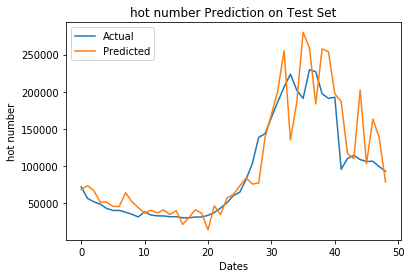

In [37]:
ax1 = plt.subplot(111)
plt.plot(test_set['hot_number'][window_len:].values.tolist())
model.eval()
prediction = model(torch.tensor(X_test).float()).squeeze().detach().numpy()
plt.plot(((prediction + 1) * test_set['hot_number'].values[:-window_len]))
plt.xlabel('Dates')
plt.ylabel('hot number')
plt.title('hot number Prediction on Test Set')
plt.legend(['Actual','Predicted'])
  
# date_list = date_labels()
# ax1.set_xticks([x for x in range(len(date_list))])
# for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
#     label.set_visible(False)

plt.show()

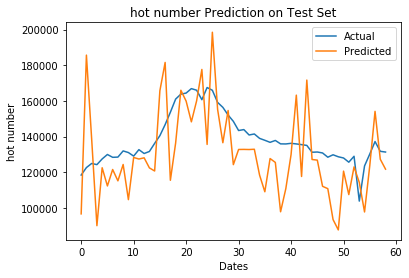

In [30]:
ax1 = plt.subplot(111)
plt.plot(test_set['hot_number'][window_len:].values.tolist())
model.eval()
prediction = model(torch.tensor(X_test).float()).squeeze().detach().numpy()
plt.plot(((prediction + 1) * test_set['hot_number'].values[:-window_len]))
plt.xlabel('Dates')
plt.ylabel('hot number')
plt.title('hot number Prediction on Test Set')
plt.legend(['Actual','Predicted'])
  
# date_list = date_labels()
# ax1.set_xticks([x for x in range(len(date_list))])
# for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
#     label.set_visible(False)

plt.show()

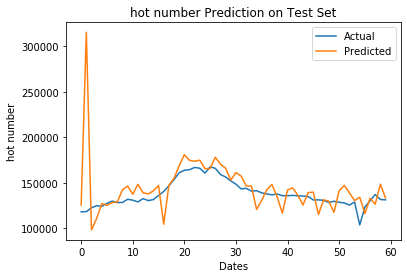

In [30]:
ax1 = plt.subplot(111)
plt.plot(test_set['hot_number'][window_len:].values.tolist())
model.eval()
prediction = model(torch.tensor(X_test).float()).squeeze().detach().numpy()
plt.plot(((prediction + 1) * test_set['hot_number'].values[:-window_len]))
plt.xlabel('Dates')
plt.ylabel('hot number')
plt.title('hot number Prediction on Test Set')
plt.legend(['Actual','Predicted'])
  
# date_list = date_labels()
# ax1.set_xticks([x for x in range(len(date_list))])
# for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
#     label.set_visible(False)

plt.show()

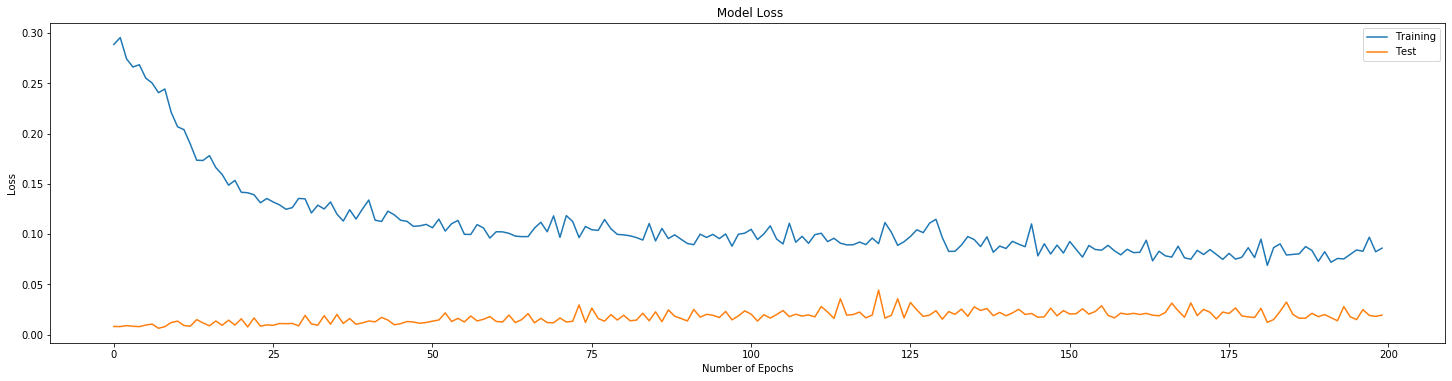

In [23]:
plt.figure(figsize=(25, 20))
plt.subplot(311)
plt.plot([i for i in range(epochs)], train_loss)
plt.plot([i for i in range(epochs)], test_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title(' Model Loss')
plt.legend(['Training', 'Test'])
plt.show()

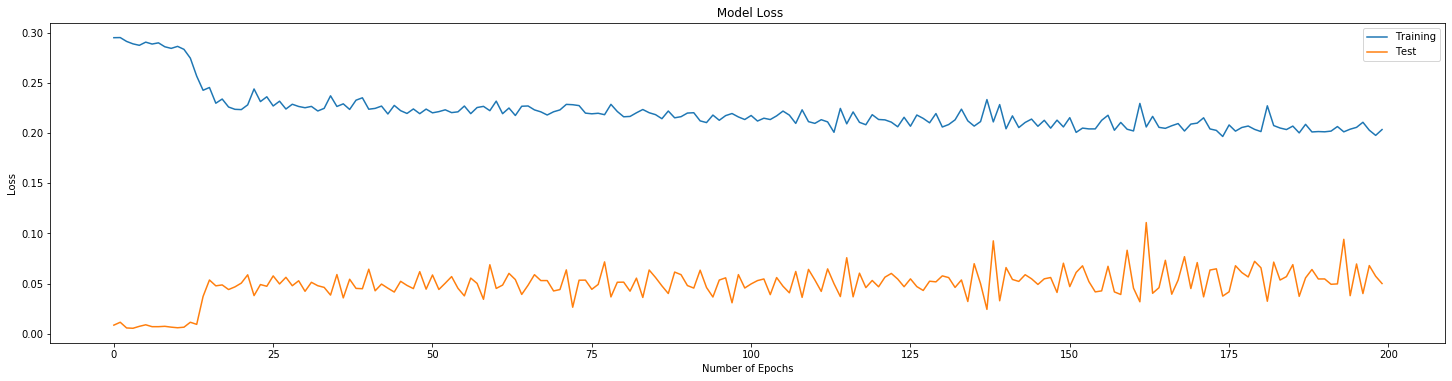

In [23]:
plt.figure(figsize=(25, 20))
plt.subplot(311)
plt.plot([i for i in range(epochs)], train_loss)
plt.plot([i for i in range(epochs)], test_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title(' Model Loss')
plt.legend(['Training', 'Test'])
plt.show()

In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader

epochs = 150
lr = 5e-4
window_len = 4
input_size = 4
hidden_size = 128
num_layers = 2
dropout = 0.25

class RNN_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=num_layers, dropout=dropout):
        super(RNN_model, self).__init__()

        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout)
        # 输出是 hot_number ，是一个一维的值
        self.linear = nn.Linear(hidden_size, out_features=1)

    def forward(self, input):
        # input : [batch, seq, hidden_size]，但 rnn 要求的输入是 [seq, batch, hidden_size]
        output, (_,_) = self.rnn(input.permute(1,0,2))
        # return 的维度是 [batch, hidden_size]
        return self.linear(output[-1])
    

def train(train_iter, test_iter, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.MSELoss()
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        l_loss = 0.
        for X, Y in train_iter:
            optimizer.zero_grad()
            l = loss(model(X.float()).squeeze(), Y.float())
            l.backward()
            optimizer.step()
            l_loss += l.item()

        train_loss.append(l_loss / len(train_iter))
        eval_loss = eval(test_iter, model, loss)
        test_loss.append(eval_loss)
        print('epoch: {}, train loss :{}'.format(epoch, l_loss / len(train_iter)))
        print('epoch: {}, eval loss :{}'.format(epoch, eval_loss))
    return train_loss, test_loss


def eval(test_iter, model, loss):
    model.eval()
    l_loss = 0.
    for X, Y in test_iter:
        with torch.no_grad():
            l = loss(model(X.float()).squeeze(), Y.float())
            l_loss += l.item()
    
    return l_loss / len(test_iter)

In [23]:
model = RNN_model(input_size, hidden_size)
train_loss, test_loss = train(train_iter, test_iter, model)

/usr/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, train loss :1.015699598651666
epoch: 0, eval loss :0.27104530377047403
epoch: 1, train loss :0.9152082823790036
epoch: 1, eval loss :0.21540493943861552
epoch: 2, train loss :0.8557339253333899
epoch: 2, eval loss :0.24513692940984452
epoch: 3, train loss :0.7973558627642118
epoch: 3, eval loss :0.21337261476687022
epoch: 4, train loss :0.7247364509564179
epoch: 4, eval loss :0.23603257802980288
epoch: 5, train loss :0.6699572159693792
epoch: 5, eval loss :0.16825808371816361
epoch: 6, train loss :0.6087252715459237
epoch: 6, eval loss :0.18942097680909292
epoch: 7, train loss :0.5859358110106908
epoch: 7, eval loss :0.15186722789491927
epoch: 8, train loss :0.5434962889322867
epoch: 8, eval loss :0.1684083757655961
epoch: 9, train loss :0.50133857732782
epoch: 9, eval loss :0.1827657430299691
epoch: 10, train loss :0.49606908972446734
epoch: 10, eval loss :0.15452266590935843
epoch: 11, train loss :0.47024103655264926
epoch: 11, eval loss :0.13407605407493456
epoch: 12, trai

epoch: 98, train loss :0.27810230650580847
epoch: 98, eval loss :0.11620952215577875
epoch: 99, train loss :0.2931335221689481
epoch: 99, eval loss :0.14722973800131253
epoch: 100, train loss :0.28755821688817096
epoch: 100, eval loss :0.11328469216823578
epoch: 101, train loss :0.2806958579100095
epoch: 101, eval loss :0.11722198075481824
epoch: 102, train loss :0.28249211638019633
epoch: 102, eval loss :0.12088694955621447
epoch: 103, train loss :0.28760779391114527
epoch: 103, eval loss :0.11257040434117828
epoch: 104, train loss :0.28768600451831633
epoch: 104, eval loss :0.14459248525755747
epoch: 105, train loss :0.2765235635810174
epoch: 105, eval loss :0.21453156428677694
epoch: 106, train loss :0.28239999596889204
epoch: 106, eval loss :0.1000768646065678
epoch: 107, train loss :0.29110376708782637
epoch: 107, eval loss :0.11834993958473206
epoch: 108, train loss :0.28986219889842546
epoch: 108, eval loss :0.10518797733155745
epoch: 109, train loss :0.2821647725426234
epoch: 1

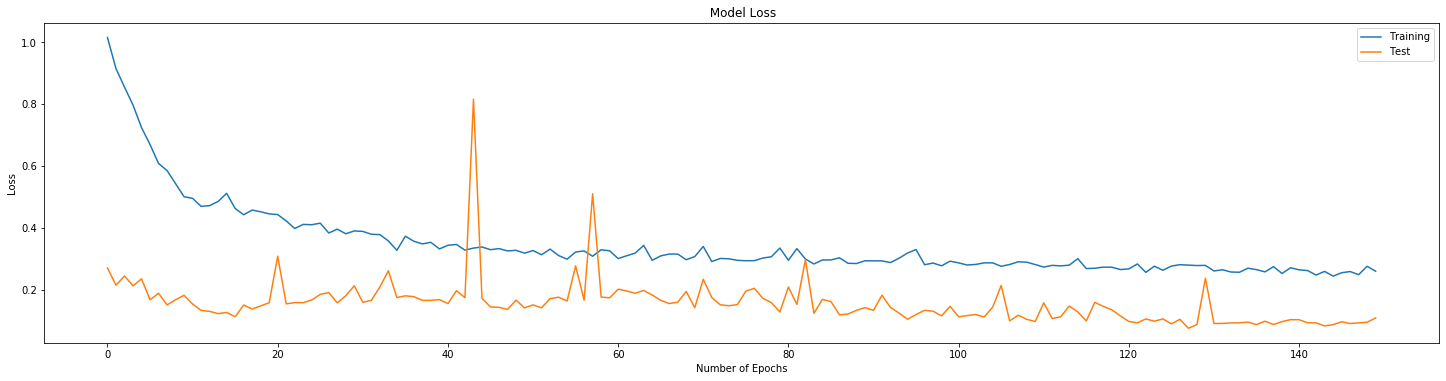

In [24]:
plt.figure(figsize=(25, 20))
plt.subplot(311)
plt.plot([i for i in range(epochs)], train_loss)
plt.plot([i for i in range(epochs)], test_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title(' Model Loss')
plt.legend(['Training', 'Test'])
plt.show()

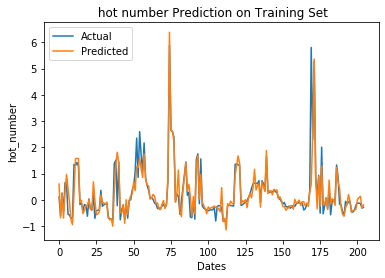

In [25]:
plt.subplot(111)
plt.plot(torch.tensor(Y_train))
model.eval()
prediction = model(torch.tensor(X_train).float()).squeeze().detach().numpy()
plt.plot(prediction)
plt.xlabel('Dates')
plt.ylabel('hot_number')
plt.title(' hot number Prediction on Training Set')
plt.legend(['Actual','Predicted'])

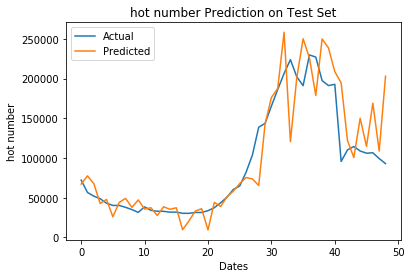

In [26]:
ax1 = plt.subplot(111)
plt.plot(test_set['hot_number'][window_len:].values.tolist())
model.eval()
prediction = model(torch.tensor(X_test).float()).squeeze().detach().numpy()
plt.plot(((prediction + 1) * test_set['hot_number'].values[:-window_len]))
plt.xlabel('Dates')
plt.ylabel('hot number')
plt.title('hot number Prediction on Test Set')
plt.legend(['Actual','Predicted'])
  
# date_list = date_labels()
# ax1.set_xticks([x for x in range(len(date_list))])
# for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
#     label.set_visible(False)

plt.show()